# Don't Leave Me Blue: Using ML To Improve Bluebikes' Reliability

## Table of Contents <a id="contents"></a>

- [**Background and Motivation**](#background)
   
- [**Setup**](#setup)

- [**Data Collection, Engineering, & Validation**](#part1)
    - [Historic Trip Data](#part1-1) (`trips_df`)
    - [Station Info](#part1-2) (`station_info_df`)
    - [Interpolating Historic Bike/Dock Availability per Station](#part1-3) (`availability_df`)
    - [Weather & Background Data](#part1-4)
    - [Choosing Relevant Stations](#part1-5)

- [**Exploratory Data Analysis**](#part2)
  
- [**Modeling and Machine Learning**](#part3)
  - Feature Engineering & Feature Selection
  - Predicting Bike and Station Availability
      - Linear Regression (Baseline)
      - Random Forest
      - AdaBoost
  - Model Interpretation & Comparison
 
- [**Model Deployment**](#part4)

- [**Other/Playground**](#other)
    - [Notes](#notes)

## Background and Motivation <a id="background"></a>
[Return to contents](#contents)

In this notebook, I build a prototype of a new feature that would improve the reliability of Bluebikes, a bike-sharing platform in Boston, for users' daily commute. I design functionality that would allow users to input their origin and desired destination, then receive a prediction from an ML algorithm:
- what station they should get a bike from,
- where they should go to reach their destination, 
- what the likelihood is of them finding a free dock at their destination to park their bike and end the ride. 

This custom prediction model considers the current bikes/docks availability at origin and destination stations, as well as current weather, time of the day, day of the week, etc. and historical Bluebikes usage data.

# Setup <a id="setup"></a>
[Return to contents](#contents)

In [111]:
# Import necessary libraries
from os.path import exists
import urllib
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Collection & Engineering <a id="part1"></a>
[Return to contents](#contents)

I'm going to create and preprocess a dataset using publicly-available Bluebikes [system data](https://www.bluebikes.com/system-data), supplementing it with the relevant background information such as weather and environment data. 

### Historic Trip Data <a id="part1-1"></a>
[Return to contents](#contents)

I downloaded Bluebikes [trip history data](https://s3.amazonaws.com/hubway-data/index.html) from July 2020 to September 2021. I will first perform cleaning & preprocessing on one month's dataset to understand what needs to be changed before the data can be used for analysis and modeling. Then, I'll create a cleaning and preprocessing pipeline, and apply it to compile a multiple-year trip history dataset.

#### Read-in data

In [112]:
# Read in one sample dataset
trips_2020_07 = pd.read_csv('data/202007-bluebikes-tripdata.csv')
display(trips_2020_07.head())
display(trips_2020_07.info())
display(trips_2020_07.isna().sum())
display(trips_2020_07.describe())

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,259,2020-07-01 00:01:15.0430,2020-07-01 00:05:34.1010,16,Back Bay T Stop - Dartmouth St at Stuart St,42.348074,-71.076570,26,Washington St at Waltham St,42.341575,-71.068904,6059,Subscriber,02118
1,436,2020-07-01 00:03:39.1810,2020-07-01 00:10:55.4600,6,Cambridge St at Joy St,42.361257,-71.065287,152,Ink Block - Harrison Ave at Herald St,42.345901,-71.063187,2322,Customer,02114
2,1346,2020-07-01 00:04:27.0790,2020-07-01 00:26:53.2030,404,Mass Ave T Station,42.341356,-71.083370,167,Ryan Playground - Dorchester Ave at Harbor Vie...,42.317642,-71.056664,4062,Customer,NaN
3,2069,2020-07-01 00:04:56.0140,2020-07-01 00:39:25.1100,436,Maverick St at Massport Path,42.367741,-71.033360,436,Maverick St at Massport Path,42.367741,-71.033360,3858,Subscriber,02128
4,1266,2020-07-01 00:05:43.0180,2020-07-01 00:26:49.0580,404,Mass Ave T Station,42.341356,-71.083370,167,Ryan Playground - Dorchester Ave at Harbor Vie...,42.317642,-71.056664,6031,Customer,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259726 entries, 0 to 259725
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             259726 non-null  int64  
 1   starttime                259726 non-null  object 
 2   stoptime                 259726 non-null  object 
 3   start station id         259726 non-null  int64  
 4   start station name       259726 non-null  object 
 5   start station latitude   259726 non-null  float64
 6   start station longitude  259726 non-null  float64
 7   end station id           259726 non-null  int64  
 8   end station name         259726 non-null  object 
 9   end station latitude     259726 non-null  float64
 10  end station longitude    259726 non-null  float64
 11  bikeid                   259726 non-null  int64  
 12  usertype                 259726 non-null  object 
 13  postal code              230479 non-null  object 
dtypes: f

None

tripduration                   0
starttime                      0
stoptime                       0
start station id               0
start station name             0
start station latitude         0
start station longitude        0
end station id                 0
end station name               0
end station latitude           0
end station longitude          0
bikeid                         0
usertype                       0
postal code                29247
dtype: int64

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid
count,2.597260e+05,259726.000000,259726.000000,259726.000000,259726.000000,259726.000000,259726.000000,259726.000000
mean,2.320020e+03,162.399540,42.354993,-71.086877,161.173818,42.354872,-71.086755,4233.672366
std,3.234821e+04,133.904613,0.018732,0.027911,133.891372,0.018805,0.027893,1245.847556
min,6.100000e+01,1.000000,42.167226,-71.166491,1.000000,42.167226,-71.166491,31.000000
25%,5.570000e+02,54.000000,42.344137,-71.105668,53.000000,42.343749,-71.105495,3170.000000
50%,9.580000e+02,113.000000,42.353391,-71.086336,111.000000,42.353334,-71.085954,4251.000000
75%,1.633000e+03,239.000000,42.365445,-71.065287,236.000000,42.365445,-71.065287,5328.000000
max,3.030358e+06,455.000000,42.414963,-70.905558,455.000000,42.414963,-70.905558,6332.000000


#### Convert data types

The data type of `starttime` and `stoptime` columns is an object, which is not the best way to store date information. Instead, I should convert these columns to datetime data type. Data types for the other variables seem reasonable.

In [113]:
# Convert starttime and stoptime of each trip to datetime
trips_2020_07['starttime'] = pd.to_datetime(trips_2020_07['starttime'])
trips_2020_07['stoptime'] = pd.to_datetime(trips_2020_07['stoptime'])

In [114]:
# Convert tripduration from seconds to minutes for more intuitive values
trips_2020_07['tripduration'] = trips_2020_07['tripduration']/60

#### Clean column and variable names, rearrange
Leave only select columns that will be needed for data engineering. For example, postal code and user type can be dropped, as well as station names and geographical location, since this information can be recovered from the station dataset by joining on station id.

In [115]:
# Rename stoptime column to endtime for consistent column naming
trips_2020_07.rename(columns={'stoptime': 'endtime'}, inplace=True)

In [116]:
# Replace spaces in column names with underscores
trips_2020_07.columns = trips_2020_07.columns.str.replace(' ','_')

In [117]:
trips_2020_07.columns

Index(['tripduration', 'starttime', 'endtime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'postal_code'],
      dtype='object')

In [118]:
# Select relevant columns and rearrange
column_order = ['bikeid', 'tripduration', 'starttime', 'endtime', 'start_station_id', 'end_station_id']
trips_2020_07_reordered = trips_2020_07[column_order]

#### Display preprocessed dataset

In [119]:
# Display dataset after preprocessing
display(trips_2020_07_reordered.head())
display(trips_2020_07_reordered.info())

,bikeid,tripduration,starttime,endtime,start_station_id,end_station_id
0,6059,4.316667,2020-07-01 00:01:15.043,2020-07-01 00:05:34.101,16,26
1,2322,7.266667,2020-07-01 00:03:39.181,2020-07-01 00:10:55.460,6,152
2,4062,22.433333,2020-07-01 00:04:27.079,2020-07-01 00:26:53.203,404,167
3,3858,34.483333,2020-07-01 00:04:56.014,2020-07-01 00:39:25.110,436,436
4,6031,21.100000,2020-07-01 00:05:43.018,2020-07-01 00:26:49.058,404,167


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259726 entries, 0 to 259725
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   bikeid            259726 non-null  int64         
 1   tripduration      259726 non-null  float64       
 2   starttime         259726 non-null  datetime64[ns]
 3   endtime           259726 non-null  datetime64[ns]
 4   start_station_id  259726 non-null  int64         
 5   end_station_id    259726 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 11.9 MB


None

#### Create preprocessing pipeline and merge trip history data from multiple months 

In [120]:
# Funciton to preprocess a month's historic trip data
def preprocess(month_df, column_order = ['bikeid', 'tripduration', 'starttime', \
                                         'endtime', 'start_station_id', 'end_station_id']):
    
        # Convert starttime and stoptime of each trip to datetime
        month_df['starttime'] = pd.to_datetime(month_df['starttime'])
        month_df['stoptime'] = pd.to_datetime(month_df['stoptime'])
        
        # Convert tripduration from seconds to minutes for more intuitive values
        month_df['tripduration'] = month_df['tripduration']/60
        
        # Rename stoptime column to endtime for consistent column naming
        month_df.rename(columns={'stoptime': 'endtime'}, inplace=True)
        
        # Replace spaces in column names with underscores
        month_df.columns = month_df.columns.str.replace(' ','_')
        
        month_df = month_df[column_order]
        
        return month_df
    
# Function to read-in all monthly datasets in a given timerange, 
# apply preprocessing to each, and merge all into a single trips df
def read_trips_data(startyear = 2020,
                    endyear = 2021,
                    data_dir = 'data/',
                    data_name_ending = '-bluebikes-tripdata.csv'):
    
    # List to store all monthly df's
    month_dfs = []
    for year in range(startyear, endyear+1):
        
        for month in range(1, 13):
            data_path = data_dir + str(year) + str(f'{month:02d}') + data_name_ending
            if exists(data_path):
                month_df = pd.read_csv(data_path)
                print(f'data: {month} {year}')
                print(f'number of bike trips: {len(month_df)}')
                month_dfs.append(month_df)
    
    # Concat all monthly df's into one
    trips_df = pd.concat(month_dfs) 
    
    # Preprocess the resulting df
    trips_df = preprocess(trips_df)
    trips_df = trips_df.reset_index(drop=True)
    
    display(trips_df.head(10))
    display(trips_df.info())

    return trips_df

In [121]:
trips_df = read_trips_data()

data: 7 2020
number of bike trips: 259726
data: 8 2020
number of bike trips: 289033
data: 9 2020
number of bike trips: 307853
data: 10 2020
number of bike trips: 248424
data: 11 2020
number of bike trips: 161712
data: 12 2020
number of bike trips: 74002
data: 1 2021
number of bike trips: 71805
data: 2 2021
number of bike trips: 60447
data: 3 2021
number of bike trips: 139046
data: 4 2021
number of bike trips: 187816
data: 5 2021
number of bike trips: 270893
data: 6 2021
number of bike trips: 311969
data: 7 2021
number of bike trips: 309403
data: 8 2021
number of bike trips: 357338
data: 9 2021
number of bike trips: 432254


,bikeid,tripduration,starttime,endtime,start_station_id,end_station_id
0,6059,4.316667,2020-07-01 00:01:15.043,2020-07-01 00:05:34.101,16,26
1,2322,7.266667,2020-07-01 00:03:39.181,2020-07-01 00:10:55.460,6,152
2,4062,22.433333,2020-07-01 00:04:27.079,2020-07-01 00:26:53.203,404,167
3,3858,34.483333,2020-07-01 00:04:56.014,2020-07-01 00:39:25.110,436,436
4,6031,21.100000,2020-07-01 00:05:43.018,2020-07-01 00:26:49.058,404,167
5,2698,10.316667,2020-07-01 00:06:15.210,2020-07-01 00:16:34.821,20,190
6,5156,10.150000,2020-07-01 00:11:47.918,2020-07-01 00:21:57.163,227,226
7,4712,5.283333,2020-07-01 00:12:27.980,2020-07-01 00:17:45.430,335,185
8,2992,16.366667,2020-07-01 00:12:35.862,2020-07-01 00:28:57.965,3,15
9,4362,11.416667,2020-07-01 00:13:14.558,2020-07-01 00:24:40.345,436,436


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481721 entries, 0 to 3481720
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bikeid            int64         
 1   tripduration      float64       
 2   starttime         datetime64[ns]
 3   endtime           datetime64[ns]
 4   start_station_id  int64         
 5   end_station_id    int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 159.4 MB


None

### Station Info <a id="part1-2"></a>
[Return to contents](#contents)
Read in station information from Blubikes' live General Bikeshare Feed Specification (GBFS)

In [122]:
station_info_url = 'https://gbfs.bluebikes.com/gbfs/en/station_information.json'
station_info_response = urllib.request.urlopen(station_info_url)
station_info = json.loads(station_info_response.read())

print(station_info)

{'data': {'stations': [{'name': 'Colleges of the Fenway - Fenway at Avenue Louis Pasteur', 'rental_url': 'https://www.bluebikes.com/app?station_id=3', 'eightd_station_services': [], 'region_id': '10', 'lon': -71.10061883926392, 'electric_bike_surcharge_waiver': False, 'station_id': '3', 'rental_methods': ['KEY', 'CREDITCARD'], 'legacy_id': '3', 'station_type': 'classic', 'capacity': 15, 'has_kiosk': True, 'short_name': 'B32006', 'lat': 42.34011512249236, 'eightd_has_key_dispenser': False, 'external_id': 'f83464e4-0de8-11e7-991c-3863bb43a7d0'}, {'name': 'Tremont St at E Berkeley St', 'rental_url': 'https://www.bluebikes.com/app?station_id=4', 'eightd_station_services': [], 'region_id': '10', 'lon': -71.069616, 'electric_bike_surcharge_waiver': False, 'station_id': '4', 'rental_methods': ['KEY', 'CREDITCARD'], 'legacy_id': '4', 'station_type': 'classic', 'capacity': 19, 'has_kiosk': True, 'short_name': 'C32000', 'lat': 42.345392, 'eightd_has_key_dispenser': False, 'external_id': 'f834658

In [123]:
num_stations = len(station_info['data']['stations'])

# Extract relevant info
station_info_ids = pd.to_numeric([station_info['data']['stations'][i]['station_id'] for i in range(num_stations)])
station_info_names = [station_info['data']['stations'][i]['name'] for i in range(num_stations)]
station_info_latitudes = pd.to_numeric([station_info['data']['stations'][i]['lat'] for i in range(num_stations)])
station_info_longitudes = pd.to_numeric([station_info['data']['stations'][i]['lon'] for i in range(num_stations)])
station_info_capacities = pd.to_numeric([station_info['data']['stations'][i]['capacity'] for i in range(num_stations)])

# Put into a dataframe
station_info_df = pd.DataFrame({'id': station_info_ids,
                                 'name': station_info_names,
                                 'latitude': station_info_latitudes,
                                 'longitude': station_info_longitudes,
                                 'capacity': station_info_capacities})

station_info_df.set_index('id', inplace=True)

In [124]:
station_info_df.head(10)

,name,latitude,longitude,capacity
id,,,,
3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,15
4,Tremont St at E Berkeley St,42.345392,-71.069616,19
5,Northeastern University - North Parking Lot,42.341814,-71.090179,15
6,Cambridge St at Joy St,42.361257,-71.065287,15
7,Fan Pier,42.353391,-71.044571,15
8,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,19
9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,15
10,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,11
11,Longwood Ave at Binney St,42.338629,-71.106500,15


### Interpolating Historic Bike/Dock Availability per Station <a id="part1-3"></a>
[Return to contents](#contents)

To predict bike/dock availability, I need a dataset of historic bike/dock avialability at each station at any given time. While Bluebikes doesn't directly provide this information, it is possible to pretty reliably reconstruct it from the historic bike trips data (compiled in a previous section above).

Reference: [Interpolating NYC Bike Share Data to Discover Rebalancing Movements](https://towardsdatascience.com/interpolating-nyc-bike-share-data-to-discover-rebalancing-movements-6cf8a80eb902).

In [125]:
# Create a new dataframe and sort it by bikeid and by starttime 
# to follow each bike's path in sequence
trips_df_sorted = trips_df.sort_values(by=['bikeid','starttime'])
trips_df_sorted.head(10)

,bikeid,tripduration,starttime,endtime,start_station_id,end_station_id
1941,31,12.650000,2020-07-01 13:13:07.473,2020-07-01 13:25:46.676,417,60
2372,31,2.216667,2020-07-01 14:26:16.462,2020-07-01 14:28:29.833,60,60
2495,31,22.366667,2020-07-01 14:45:25.765,2020-07-01 15:07:48.706,60,186
4922,31,11.550000,2020-07-01 19:09:05.253,2020-07-01 19:20:38.726,186,40
8703,31,7.533333,2020-07-02 12:46:44.871,2020-07-02 12:54:16.892,57,51
12338,31,19.266667,2020-07-02 18:51:15.682,2020-07-02 19:10:31.816,51,362
14801,31,117.733333,2020-07-03 02:20:30.005,2020-07-03 04:18:14.566,362,362
22187,31,7.233333,2020-07-03 21:21:23.165,2020-07-03 21:28:38.043,362,161
25595,31,13.583333,2020-07-04 13:43:32.335,2020-07-04 13:57:07.894,161,47
25827,31,4.833333,2020-07-04 14:01:55.845,2020-07-04 14:06:46.179,47,190


In [126]:
# Create an offset dataframe with a single dummy record
earliest_date = trips_df_sorted['starttime'].min()
offset_df = pd.DataFrame({'starttime': pd.to_datetime(earliest_date),
                          'start_station_id':0,
                          'endtime': pd.to_datetime(earliest_date),
                          'end_station_id':0,'bikeid':0},
                          index=[0])
offset_df

,starttime,start_station_id,endtime,end_station_id,bikeid
0,2020-07-01 00:01:15.043,0,2020-07-01 00:01:15.043,0,0


In [127]:
# Create two new dataframes, one with offset first, one with it last
trips_df1 = pd.concat([offset_df,trips_df_sorted]).reset_index(drop=True)
trips_df2 = pd.concat([trips_df_sorted,offset_df]).reset_index(drop=True)

display(trips_df1.head(3))
display(trips_df2.tail(3))

,starttime,start_station_id,endtime,end_station_id,bikeid,tripduration
0,2020-07-01 00:01:15.043,0,2020-07-01 00:01:15.043,0,0,NaN
1,2020-07-01 13:13:07.473,417,2020-07-01 13:25:46.676,60,31,12.650000
2,2020-07-01 14:26:16.462,60,2020-07-01 14:28:29.833,60,31,2.216667


,bikeid,tripduration,starttime,endtime,start_station_id,end_station_id
3481719,7551,6.716667,2021-09-30 23:49:18.987,2021-09-30 23:56:02.286,446,9
3481720,7551,12.666667,2021-09-30 23:58:44.910,2021-10-01 00:11:25.601,9,342
3481721,0,NaN,2020-07-01 00:01:15.043,2020-07-01 00:01:15.043,0,0


In [128]:
# Create a df where each record represents the time period that 
# a given bike was docked at a station (time period from its 
# previous trip's endtime to its next trip's starttime)

stops_df = pd.concat([trips_df1[['bikeid','endtime','end_station_id']],
                      trips_df2[['bikeid','starttime','start_station_id']]],
                      axis=1)

stops_df.head(20)

,bikeid,endtime,end_station_id,bikeid,starttime,start_station_id
0,0,2020-07-01 00:01:15.043,0,31,2020-07-01 13:13:07.473,417
1,31,2020-07-01 13:25:46.676,60,31,2020-07-01 14:26:16.462,60
2,31,2020-07-01 14:28:29.833,60,31,2020-07-01 14:45:25.765,60
3,31,2020-07-01 15:07:48.706,186,31,2020-07-01 19:09:05.253,186
4,31,2020-07-01 19:20:38.726,40,31,2020-07-02 12:46:44.871,57
5,31,2020-07-02 12:54:16.892,51,31,2020-07-02 18:51:15.682,51
6,31,2020-07-02 19:10:31.816,362,31,2020-07-03 02:20:30.005,362
7,31,2020-07-03 04:18:14.566,362,31,2020-07-03 21:21:23.165,362
8,31,2020-07-03 21:28:38.043,161,31,2020-07-04 13:43:32.335,161
9,31,2020-07-04 13:57:07.894,47,31,2020-07-04 14:01:55.845,47


One can see that some trips end at one station, but the start of the next trip occurs at a different station. That means there was a "system rebalancing" ride, meaning that the bike was moved from one station to another by Bluebikes to control for surges in demand/supply. Such trips are removed from historic trip data, so we need to reconstruct them manually in order to then reconstruct accurate bike/dock counts at each station at any given time. 

In [129]:
# Create a dataframe to store "system rebalancing" rides as if they were
# actual trips, to account for the number of bikes moved by Bluebikes 
# in estimating bike and dock availability from the trips data

rebalancing_trips_df = stops_df.copy()

rebalancing_trips_df.columns=['bikeid1','starttime','start_station_id',
                              'bikeid2','endtime','end_station_id']

rebalancing_trips_df = rebalancing_trips_df[['starttime','start_station_id',
                                       'endtime','end_station_id', 'bikeid1']].\
                                     loc[(rebalancing_trips_df.bikeid1==rebalancing_trips_df.bikeid2) & \
                                         (rebalancing_trips_df['start_station_id'] != rebalancing_trips_df['end_station_id']) ]
rebalancing_trips_df.columns = ['starttime','start_station_id',
                                'endtime','end_station_id', 'bikeid']
rebalancing_trips_df.reset_index(drop=True, inplace=True)
rebalancing_trips_df.head(10)

,starttime,start_station_id,endtime,end_station_id,bikeid
0,2020-07-01 19:20:38.726,40,2020-07-02 12:46:44.871,57,31
1,2020-07-09 15:35:46.332,9,2020-07-09 18:50:44.234,338,31
2,2020-07-03 09:32:17.571,162,2020-07-04 15:12:33.938,126,218
3,2020-07-19 20:17:18.586,27,2020-07-22 13:12:24.331,171,218
4,2020-07-28 19:28:31.675,36,2020-07-29 01:02:19.470,61,218
5,2020-07-29 17:58:36.970,186,2020-07-31 17:50:13.249,137,218
6,2020-08-18 15:38:28.376,161,2020-08-19 09:09:56.493,228,218
7,2020-08-30 14:13:48.218,459,2020-08-31 19:15:33.482,447,218
8,2020-09-06 20:16:16.019,39,2020-09-11 11:10:14.747,40,218
9,2020-09-14 10:40:48.046,454,2020-09-15 07:14:28.630,36,218


Now, I reconstructed the rebalancing trips that explain the discrepancies in `end_station_id` of one trip and the `start_station_id` of the next trip. For example, below, `bikeid` #31 ends the trip at station #40, but starts the next trip at station #57. Even though it wasn't originally in the historic trip data released by Bluebikes, there's now a corresponding rebalancing trip in the `rebalancing_trips_df` that explains this discrepancy. The bike #31 was moved from station #40 to station #57 sometime during the night of July 1-2, 2020!

In [130]:
trips_df_sorted[['starttime', 'start_station_id', 'endtime', \
                 'end_station_id', 'bikeid']].iloc[3:5]

,starttime,start_station_id,endtime,end_station_id,bikeid
4922,2020-07-01 19:09:05.253,186,2020-07-01 19:20:38.726,40,31
8703,2020-07-02 12:46:44.871,57,2020-07-02 12:54:16.892,51,31


In [131]:
rebalancing_trips_df.head(1)

,starttime,start_station_id,endtime,end_station_id,bikeid
0,2020-07-01 19:20:38.726,40,2020-07-02 12:46:44.871,57,31


I now need to merge all these rebalancing trips into the original trips dataset to obtain the full dataset of trips.

In [132]:
all_trips_df = pd.concat([trips_df_sorted[['starttime', 'start_station_id', 
                                           'endtime', 'end_station_id', 'bikeid']],
                          rebalancing_trips_df])
all_trips_df.sort_values(by=['bikeid', 'starttime'], inplace=True)
all_trips_df.reset_index(drop=True, inplace=True)

# This dataset represent all bike movements that occured, so it can be used to 
# intrepolate bikes and docks availability at each station
all_trips_df.head(10)

,starttime,start_station_id,endtime,end_station_id,bikeid
0,2020-07-01 13:13:07.473,417,2020-07-01 13:25:46.676,60,31
1,2020-07-01 14:26:16.462,60,2020-07-01 14:28:29.833,60,31
2,2020-07-01 14:45:25.765,60,2020-07-01 15:07:48.706,186,31
3,2020-07-01 19:09:05.253,186,2020-07-01 19:20:38.726,40,31
4,2020-07-01 19:20:38.726,40,2020-07-02 12:46:44.871,57,31
5,2020-07-02 12:46:44.871,57,2020-07-02 12:54:16.892,51,31
6,2020-07-02 18:51:15.682,51,2020-07-02 19:10:31.816,362,31
7,2020-07-03 02:20:30.005,362,2020-07-03 04:18:14.566,362,31
8,2020-07-03 21:21:23.165,362,2020-07-03 21:28:38.043,161,31
9,2020-07-04 13:43:32.335,161,2020-07-04 13:57:07.894,47,31


All the `end_station_id`s and subsequent `start_station_id` are now consistent, which means I can proceed to the next step of actually reconstructing historic bike/dock availability at any given time at every station.

In [133]:
# Create two separate dataframes from trips data: bike pick-ups (taking out a bike)
# and bike drop-offs (docking) to track the changes in number of bikes at each station
pick_ups_df = all_trips_df[['starttime','start_station_id']].assign(change=-1)
drop_offs_df = all_trips_df[['endtime','end_station_id']].assign(change=+1)

display(pick_ups_df.head(5))
display(drop_offs_df.head(5))

,starttime,start_station_id,change
0,2020-07-01 13:13:07.473,417,-1
1,2020-07-01 14:26:16.462,60,-1
2,2020-07-01 14:45:25.765,60,-1
3,2020-07-01 19:09:05.253,186,-1
4,2020-07-01 19:20:38.726,40,-1


,endtime,end_station_id,change
0,2020-07-01 13:25:46.676,60,1
1,2020-07-01 14:28:29.833,60,1
2,2020-07-01 15:07:48.706,186,1
3,2020-07-01 19:20:38.726,40,1
4,2020-07-02 12:46:44.871,57,1


In [134]:
# Create a df to track changes in number of bikes by station
pick_ups_df.columns=['time','station_id','change']
drop_offs_df.columns=['time','station_id','change']
changes_df = pd.concat([pick_ups_df,drop_offs_df])
changes_df.sort_values(by=['time'], inplace=True) 
changes_df.reset_index(drop=True, inplace=True) 

# All bike pick-ups and bike drop-offs by station are now in chronological order
changes_df.head(10)

,time,station_id,change
0,2020-07-01 00:01:15.043,16,-1
1,2020-07-01 00:03:39.181,6,-1
2,2020-07-01 00:04:27.079,404,-1
3,2020-07-01 00:04:56.014,436,-1
4,2020-07-01 00:05:34.101,26,1
5,2020-07-01 00:05:43.018,404,-1
6,2020-07-01 00:06:15.210,20,-1
7,2020-07-01 00:10:55.460,152,1
8,2020-07-01 00:11:47.918,227,-1
9,2020-07-01 00:12:27.980,335,-1


The dataframe above displays all changes in the numbers of bikes available (as a result of bike pick-ups and drop-offs) across all stations in chronological order. Essentially, it shows every action taken (bike pick-up/drop-off) by users across the entire Bluebikes system in chronological order.

#### Reconstructed historic bike/dock availability for a sample station

In [135]:
# Extract id for a desired station name
sample_station_name = 'Central Square at Mass Ave / Essex St'
sample_station_id = station_info_df.loc[station_info_df['name'] == \
                                          sample_station_name].index[0]
sample_station_id = int(sample_station_id)

print(f'{sample_station_id} is the station ID for "{sample_station_name}"')

68 is the station ID for "Central Square at Mass Ave / Essex St"


In [136]:
# Retrieve rows from the changes_df relevant to the bike count 
# changes at a desired station
sample_station_availability_df = changes_df.loc[(changes_df.station_id == sample_station_id)]
sample_station_availability_df.reset_index(drop=True, inplace=True)

# Calculate cumulative counts of bikes at a desired station 
# (starting from zero)
sample_station_availability_df = \
sample_station_availability_df.assign(bikes_available = \
                                      sample_station_availability_df.change.cumsum())

sample_station_availability_df.head(15)

,time,station_id,change,bikes_available
0,2020-07-01 01:40:26.088,68,-1,-1
1,2020-07-01 05:12:19.600,68,1,0
2,2020-07-01 05:47:34.947,68,-1,-1
3,2020-07-01 06:52:47.602,68,-1,-2
4,2020-07-01 06:54:25.225,68,-1,-3
5,2020-07-01 07:29:07.737,68,-1,-4
6,2020-07-01 07:34:31.706,68,-1,-5
7,2020-07-01 07:52:58.954,68,1,-4
8,2020-07-01 08:01:47.069,68,1,-3
9,2020-07-01 08:10:54.244,68,1,-2


I don't know what number of bikes each station starts at. Therefore, I need to correct the starting number to make sure that the count of bikes at a sample station in my reconstructed dataset never drops below zero.


In [137]:
sample_station_availability_df.at[0, 'change'] =+ \
abs(sample_station_availability_df.change.cumsum().min()) - 1

# Recalculate cumulative counts of bikes at a desired station (this time 
# starting from some fixed number that ensures count doesn't drop below 0)
sample_station_availability_df = \
sample_station_availability_df.assign(bikes_available = \
                                      sample_station_availability_df.change.cumsum())

sample_station_availability_df.head(15)

,time,station_id,change,bikes_available
0,2020-07-01 01:40:26.088,68,10,10
1,2020-07-01 05:12:19.600,68,1,11
2,2020-07-01 05:47:34.947,68,-1,10
3,2020-07-01 06:52:47.602,68,-1,9
4,2020-07-01 06:54:25.225,68,-1,8
5,2020-07-01 07:29:07.737,68,-1,7
6,2020-07-01 07:34:31.706,68,-1,6
7,2020-07-01 07:52:58.954,68,1,7
8,2020-07-01 08:01:47.069,68,1,8
9,2020-07-01 08:10:54.244,68,1,9


In [138]:
# Verify
count_min = sample_station_availability_df['bikes_available'].min()
count_max = sample_station_availability_df['bikes_available'].max()
count_avg = sample_station_availability_df['bikes_available'].mean()


print(f'Minimum count of bikes available at {sample_station_name} is {count_min}')
print(f'Maximum count of bikes available at {sample_station_name} is {count_max}')
print(f'Average count of bikes available at {sample_station_name} is {count_avg:.2f}')

Minimum count of bikes available at Central Square at Mass Ave / Essex St is 0
Maximum count of bikes available at Central Square at Mass Ave / Essex St is 22
Average count of bikes available at Central Square at Mass Ave / Essex St is 10.91


#### Reconstructing historic bike/dock availability across ALL Bluebikes stations

In [205]:
changes_df.head(10)

,time,station_id,change
0,2020-07-01 00:01:15.043,16,-1
1,2020-07-01 00:03:39.181,6,-1
2,2020-07-01 00:04:27.079,404,-1
3,2020-07-01 00:04:56.014,436,-1
4,2020-07-01 00:05:34.101,26,1
5,2020-07-01 00:05:43.018,404,-1
6,2020-07-01 00:06:15.210,20,-1
7,2020-07-01 00:10:55.460,152,1
8,2020-07-01 00:11:47.918,227,-1
9,2020-07-01 00:12:27.980,335,-1


In [153]:
availability_df = changes_df.copy()
availability_df = \
availability_df.assign(bikes_available = availability_df\
                       .groupby('station_id').change.cumsum())

availability_df.head(10)

,time,station_id,change,bikes_available
0,2020-07-01 00:01:15.043,16,-1,-1
1,2020-07-01 00:03:39.181,6,-1,-1
2,2020-07-01 00:04:27.079,404,-1,-1
3,2020-07-01 00:04:56.014,436,-1,-1
4,2020-07-01 00:05:34.101,26,1,1
5,2020-07-01 00:05:43.018,404,-1,-2
6,2020-07-01 00:06:15.210,20,-1,-1
7,2020-07-01 00:10:55.460,152,1,1
8,2020-07-01 00:11:47.918,227,-1,-1
9,2020-07-01 00:12:27.980,335,-1,-1


Once again, need to correct for negative bike counts.

In [154]:
# Correct for negative bike counts by adding the absolute value of 
# the minimum count at each station to all of that station's counts

In [156]:
availability_df['bikes_available'] = \
availability_df.groupby('station_id')['bikes_available'].apply(lambda x: x + abs(min(x)))

availability_df.drop('change', axis=1, inplace=True)

availability_df.head(10)

,time,station_id,bikes_available
0,2020-07-01 00:01:15.043,16,8
1,2020-07-01 00:03:39.181,6,13
2,2020-07-01 00:04:27.079,404,13
3,2020-07-01 00:04:56.014,436,4
4,2020-07-01 00:05:34.101,26,10
5,2020-07-01 00:05:43.018,404,12
6,2020-07-01 00:06:15.210,20,13
7,2020-07-01 00:10:55.460,152,6
8,2020-07-01 00:11:47.918,227,3
9,2020-07-01 00:12:27.980,335,10


#### Verify correctness of vector operations outcome
I need to verify that pandas vector operations on all stations at the same time delivered the same result as the sample station availability dataframe I created previously.

In [157]:
# Subset the availability_df to only station with 'sample_station_id'
availability_df_sample_subset = \
availability_df[availability_df['station_id'] == sample_station_id]

availability_df_sample_subset.head(10)

,time,station_id,bikes_available
138,2020-07-01 01:40:26.088,68,10
280,2020-07-01 05:12:19.600,68,11
357,2020-07-01 05:47:34.947,68,10
634,2020-07-01 06:52:47.602,68,9
649,2020-07-01 06:54:25.225,68,8
846,2020-07-01 07:29:07.737,68,7
888,2020-07-01 07:34:31.706,68,6
1041,2020-07-01 07:52:58.954,68,7
1111,2020-07-01 08:01:47.069,68,8
1185,2020-07-01 08:10:54.244,68,9


In [158]:
# Once again display the sample station availability df created previously
sample_station_availability_df.head(10)

,time,station_id,change,bikes_available
0,2020-07-01 01:40:26.088,68,10,10
1,2020-07-01 05:12:19.600,68,1,11
2,2020-07-01 05:47:34.947,68,-1,10
3,2020-07-01 06:52:47.602,68,-1,9
4,2020-07-01 06:54:25.225,68,-1,8
5,2020-07-01 07:29:07.737,68,-1,7
6,2020-07-01 07:34:31.706,68,-1,6
7,2020-07-01 07:52:58.954,68,1,7
8,2020-07-01 08:01:47.069,68,1,8
9,2020-07-01 08:10:54.244,68,1,9


Visually, all counts appear the same, which is great news! But let's perform a final validation.

In [159]:
# Validate all counts are the same across sample_station_availability_df
# and the subset from the entire availability_df
num_differences = \
sum(sample_station_availability_df['bikes_available'].values != \
    availability_df_sample_subset['bikes_available'].values)

print(f'Number of differing entries: {num_differences}')

Number of differing entries: 0


#### Transforming `availability_df` into 15-minute intervals availability data
Ultimately, I want to be able to make predictions in 15-minute increment horizons. Therefore, I need to transform the data in the way that I can obtain historic bike/dock availability at each station in even 15 minute increments, instead of uneven intervals that I have right now that capture every single bike count change in a chronological order.

In [160]:
availability_df.head(10)

,time,station_id,bikes_available
0,2020-07-01 00:01:15.043,16,8
1,2020-07-01 00:03:39.181,6,13
2,2020-07-01 00:04:27.079,404,13
3,2020-07-01 00:04:56.014,436,4
4,2020-07-01 00:05:34.101,26,10
5,2020-07-01 00:05:43.018,404,12
6,2020-07-01 00:06:15.210,20,13
7,2020-07-01 00:10:55.460,152,6
8,2020-07-01 00:11:47.918,227,3
9,2020-07-01 00:12:27.980,335,10


In [185]:
availability_df_for_resampling = availability_df.copy()

Because times aren't unique (I added rebalancing trips), I need to add minor ($ \sim\mathcal{N}(0,10)$ seconds) noise to the time data so that indexes become unique and I can perform pandas time series operations such as resampling.

In [186]:
def add_noise(time):
    return time + datetime.timedelta(seconds=np.random.normal(0,10))

In [187]:
availability_df_for_resampling['time'] = availability_df_for_resampling['time'].apply(add_noise)
availability_df_for_resampling.set_index('time', inplace=True)

In [188]:
availability_df_for_resampling.index.nunique()

7203190

In [189]:
len(availability_df_for_resampling.index)

7203190

In [190]:
availability_15_min_df = availability_df_for_resampling.groupby('station_id').resample('15min', closed='right').ffill()
availability_5_min_df = availability_df_for_resampling.groupby('station_id').resample('5min', closed='right').ffill()

In [191]:
availability_15_min_df = availability_15_min_df.drop('station_id', axis=1).reset_index()
availability_5_min_df = availability_5_min_df.drop('station_id', axis=1).reset_index()

In [901]:
availability_15_min_df.tail(20)

,station_id,time,bikes_available
16367643,549,2021-09-30 19:00:00,2
16367644,549,2021-09-30 19:15:00,3
16367645,549,2021-09-30 19:30:00,3
16367646,549,2021-09-30 19:45:00,3
16367647,549,2021-09-30 20:00:00,3
16367648,549,2021-09-30 20:15:00,3
16367649,549,2021-09-30 20:30:00,5
16367650,549,2021-09-30 20:45:00,5
16367651,549,2021-09-30 21:00:00,7
16367652,549,2021-09-30 21:15:00,7


In [907]:
availability_5_min_df.tail(20)

,station_id,time,bikes_available
49102100,549,2021-09-30 22:05:00,9
49102101,549,2021-09-30 22:10:00,9
49102102,549,2021-09-30 22:15:00,9
49102103,549,2021-09-30 22:20:00,9
49102104,549,2021-09-30 22:25:00,9
49102105,549,2021-09-30 22:30:00,9
49102106,549,2021-09-30 22:35:00,9
49102107,549,2021-09-30 22:40:00,9
49102108,549,2021-09-30 22:45:00,9
49102109,549,2021-09-30 22:50:00,10


#### Verify correctness of vector operations outcome
I need to verify that pandas vector operations on all stations at the same time delivered the correct result.

In [208]:
sample_station_id = 97

# Subset the availability_df to only station with 'sample_station_id'

availability_df_sample_subset = \
availability_df[availability_df['station_id'] == sample_station_id]

availability_df_sample_subset[4:34]

,time,station_id,bikes_available
1078,2020-07-01 07:58:16.119,97,15
1266,2020-07-01 08:20:56.149,97,14
2296,2020-07-01 09:59:13.682,97,15
2367,2020-07-01 10:07:52.738,97,14
2385,2020-07-01 10:09:35.966,97,13
2387,2020-07-01 10:10:07.207,97,12
2397,2020-07-01 10:10:58.515,97,11
2657,2020-07-01 10:48:08.388,97,10
2916,2020-07-01 11:21:28.667,97,11
3241,2020-07-01 12:03:03.115,97,12


In [209]:
availability_15_min_subset_df = availability_15_min_df[availability_15_min_df['station_id'] == sample_station_id]
availability_15_min_subset_df[29:62]

,station_id,time,bikes_available
3817601,97,2020-07-01 08:00:00,15
3817602,97,2020-07-01 08:15:00,15
3817603,97,2020-07-01 08:30:00,14
3817604,97,2020-07-01 08:45:00,14
3817605,97,2020-07-01 09:00:00,14
3817606,97,2020-07-01 09:15:00,14
3817607,97,2020-07-01 09:30:00,14
3817608,97,2020-07-01 09:45:00,14
3817609,97,2020-07-01 10:00:00,15
3817610,97,2020-07-01 10:15:00,11


In [210]:
availability_5_min_subset_df = availability_5_min_df[availability_5_min_df['station_id'] == sample_station_id]
availability_5_min_subset_df[87:186]

,station_id,time,bikes_available
11452632,97,2020-07-01 07:50:00,16
11452633,97,2020-07-01 07:55:00,16
11452634,97,2020-07-01 08:00:00,15
11452635,97,2020-07-01 08:05:00,15
11452636,97,2020-07-01 08:10:00,15
...,...,...,...
11452726,97,2020-07-01 15:40:00,8
11452727,97,2020-07-01 15:45:00,8
11452728,97,2020-07-01 15:50:00,8
11452729,97,2020-07-01 15:55:00,8


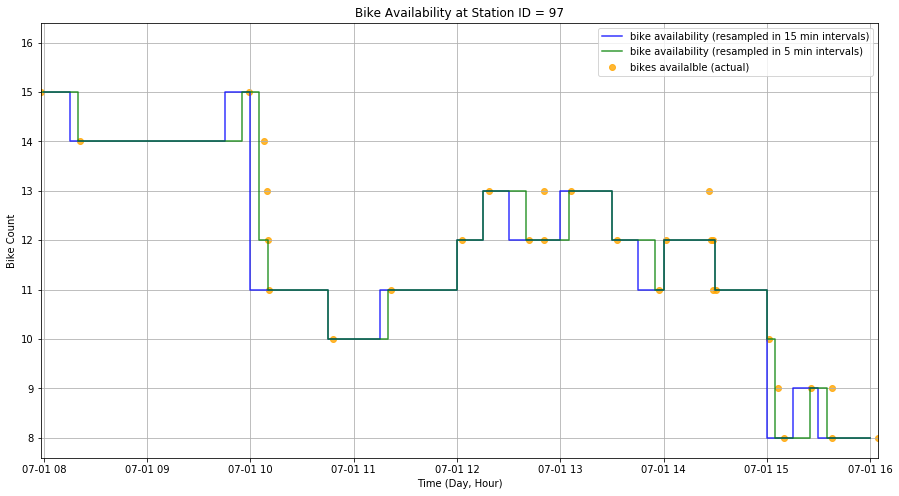

In [214]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(availability_df_sample_subset[4:34]['time'],
        availability_df_sample_subset[4:34]['bikes_available'],
        label = 'bikes availalble (actual)',
        color = 'orange',
        alpha = .8)
ax.step(availability_15_min_subset_df[29:62]['time'],
        availability_15_min_subset_df[29:62]['bikes_available'],
        label = 'bike availability (resampled in 15 min intervals)',
        color = 'blue',
        alpha = .8)
ax.step(availability_5_min_subset_df[87:186]['time'],
        availability_5_min_subset_df[87:186]['bikes_available'],
        label = 'bike availability (resampled in 5 min intervals)',
        color = 'green',
        alpha = .8)
ax.set_title(f'Bike Availability at Station ID = {sample_station_id}')
ax.set_xlabel('Time (Day, Hour)')
ax.set_ylabel('Bike Count')
ax.set_xlim(availability_df_sample_subset[4:34]['time'].min(), availability_df_sample_subset[4:34]['time'].max())
plt.grid(":")
plt.legend()
plt.show()

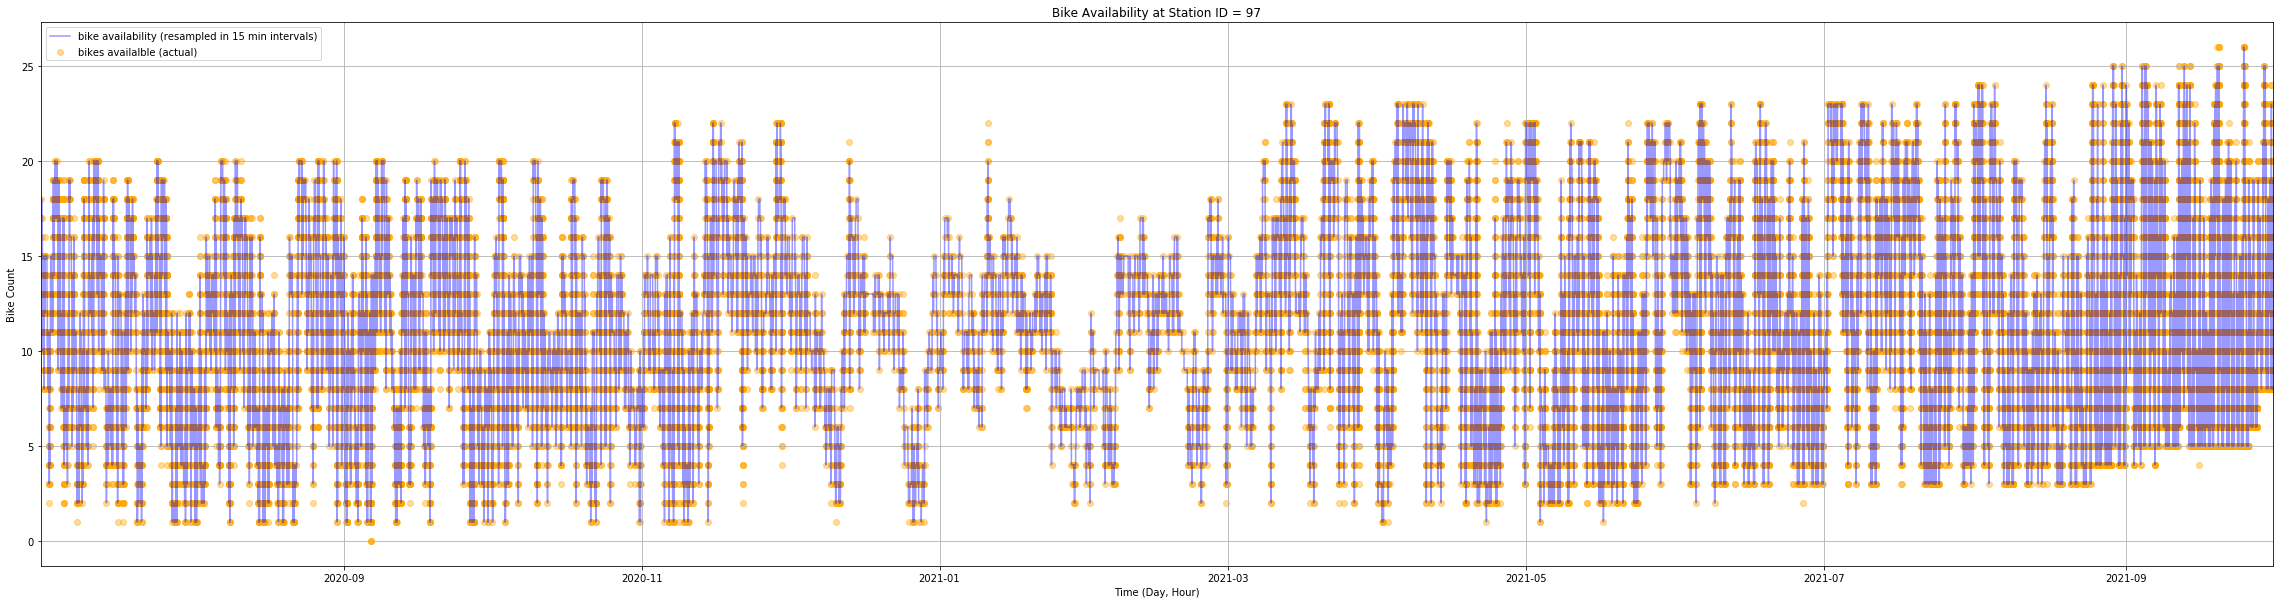

In [219]:
fig, ax = plt.subplots(figsize=(40,10))
ax.scatter(availability_df_sample_subset['time'],
        availability_df_sample_subset['bikes_available'],
        label = 'bikes availalble (actual)',
        color = 'orange',
        alpha = .4)
ax.step(availability_15_min_subset_df['time'],
        availability_15_min_subset_df['bikes_available'],
        label = 'bike availability (resampled in 15 min intervals)',
        color = 'blue',
        alpha = .4)
ax.set_title(f'Bike Availability at Station ID = {sample_station_id}')
ax.set_xlabel('Time (Day, Hour)')
ax.set_ylabel('Bike Count')
ax.set_xlim(availability_df_sample_subset['time'].min(), availability_df_sample_subset['time'].max())
plt.grid(":")
plt.legend()
plt.show()

Looks like resampling data in even 15 minute intervals worked! This way, the dataset represents bike availability in even intervals instead of capturing every single bike count change. The 5-minute interval dataset is plotted for comparison.

#### Extract Time Attributes

In [229]:
# Function to assign 0 to 2020 and 1 to 2021
def encode_year(x):
    return np.int64(np.floor(x-2020))

def extract_time_attributes(df):

    ## Create a few other date-related columns based on time variable
    # extract just the date from 'time'
    df['date'] = df.time.dt.date

    # extract 'year'
    df['year'] = df.time.dt.year

    # extract 'month'
    df['month'] = df.time.dt.month

    # extract 'weekday'
    df['weekday'] = df.time.dt.weekday

    # extract 'hour'
    df['hour'] = df.time.dt.hour

    # extract 'minute'
    df['minute'] = df.time.dt.minute
    
    # encode 'year' column with 0 and 1
    df['year'] = df['year'].apply(encode_year)
    
    return df

In [230]:
availability_df = extract_time_attributes(availability_15_min_df)
availability_df.head(10)

,station_id,time,bikes_available,date,year,month,weekday,hour,minute
0,1,2020-07-01 12:30:00,2,2020-07-01,0,7,2,12,30
1,1,2020-07-01 12:45:00,2,2020-07-01,0,7,2,12,45
2,1,2020-07-01 13:00:00,2,2020-07-01,0,7,2,13,0
3,1,2020-07-01 13:15:00,2,2020-07-01,0,7,2,13,15
4,1,2020-07-01 13:30:00,3,2020-07-01,0,7,2,13,30
5,1,2020-07-01 13:45:00,3,2020-07-01,0,7,2,13,45
6,1,2020-07-01 14:00:00,3,2020-07-01,0,7,2,14,0
7,1,2020-07-01 14:15:00,3,2020-07-01,0,7,2,14,15
8,1,2020-07-01 14:30:00,3,2020-07-01,0,7,2,14,30
9,1,2020-07-01 14:45:00,3,2020-07-01,0,7,2,14,45


#### Data Validation <a id="validation"></a>

While the reconstructed bike/dock availability dataset cannot be fully accurate (because of its nature of being interpolated from historic bike trips data), it should still provide a valid estimation of bike/dock availability across stations.

One way to validate the availability dataset is to analyze `bikes_available` counts across each station. They should all have non-negative minimum values.

In [231]:
availability_df.groupby('station_id')['bikes_available'].describe()

,count,mean,std,min,25%,50%,75%,max
station_id,,,,,,,,
1,44111.0,3.958536,1.820194,0.0,3.0,4.0,5.0,15.0
3,43871.0,6.825374,4.343663,0.0,3.0,6.0,10.0,22.0
4,43841.0,11.338747,5.406286,0.0,7.0,11.0,15.0,28.0
5,43854.0,6.638140,4.342435,0.0,3.0,5.0,10.0,20.0
6,43872.0,10.089168,4.068007,0.0,7.0,10.0,13.0,22.0
...,...,...,...,...,...,...,...,...
544,1951.0,7.149667,4.376059,1.0,3.0,6.0,11.0,15.0
545,1710.0,2.471345,0.821057,1.0,2.0,3.0,3.0,3.0
546,803.0,1.179328,0.713406,0.0,1.0,1.0,2.0,2.0


### Weather & Background Data <a id="part1-4"></a>
[Return to contents](#contents)

### Choosing Relevant Stations <a id="part1-5"></a>
[Return to contents](#contents)

In [276]:
harvard_station_names = \
['Harvard Kennedy School at Bennett St / Eliot St',
'Harvard Square at Brattle St / Eliot St',
'Harvard Square at Mass Ave/ Dunster',
'Harvard University River Houses at DeWolfe St / Cowperthwaite St',
'Harvard Law School at Mass Ave / Jarvis St',
'Harvard University Gund Hall at Quincy St / Kirkland St',
'Verizon Innovation Hub 10 Ware Street',
'Harvard University / SEAS Cruft-Pierce Halls at 29 Oxford St',
'Harvard University Housing - 115 Putnam Ave at Peabody Terrace',
'Harvard University Radcliffe Quadrangle at Shepard St / Garden St',
'Graham and Parks School – Linnaean St at Walker St',
'Harvard Stadium: N. Harvard St at Soldiers Field Rd',
'Innovation Lab - 125 Western Ave at Batten Way',
'175 N Harvard St',
'Soldiers Field Park - 111 Western Ave']        

In [275]:
harvard_station_ids = station_info_df[station_info_df["name"].isin(harvard_station_names)].index.values

In [279]:
availability_harvard_df = availability_df[availability_df.station_id.isin(harvard_station_ids)]

# Exploratory Data Analysis <a id="part2"></a>
[Return to contents](#contents)

<b><font color='red'>[TODO]</font></b>
After compiling a dataset in the previous step, the final features are the following:
- `date`: datetime format
- `year`
- `month`
- `weekday` (0 through 6, with 0 denoting Sunday)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `minute` 
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `station_id`
- `bikes_available`

# Modeling and Machine Learning <a id="part3"></a>
[Return to contents](#contents)

# Model Deployment <a id="part4"></a>
[Return to contents](#contents)

<b><font color='red'>[TODO]</font></b> Let user input desired start time, origin and destination (closest Bluebikes stops' IDs for now, extend to any location in the future). The application then retrieves current station bike/dock availability, fills in the current weather & environment conditions by sourcing from API, feeds this complete information into the model and generates predictions.

# Other <a id="other"></a>
[Return to contents](#contents)

#### User Type Conversion

`usertype` column should reflect the type of user:
- `casual`: Single Trip or Day Pass user
- `member`: Annual or Monthly Member


In [22]:
# Rename data values in the usertype column to make more intuitive
trips_2020_07.usertype.replace({'Customer': 'casual',
                                'Subscriber': 'member'},
                              inplace=True)

In [23]:
# verify values
print(trips_2020_07.usertype.unique())

['member' 'casual']


In [ ]:

# Rename data values in the usertype column to make more intuitive
trips_2020_07.usertype.replace({'Customer': 'casual',
                                'Subscriber': 'member'},
                              inplace=True)

#### Validating `availability_df`

In [430]:
availability_validation_df.sort_values('bikes_available').head(20)

,station_id,bikes_available
431,547,1
327,438,1
430,546,2
429,545,3
426,542,4
218,308,4
219,317,5
422,538,5
379,493,6
384,498,6


In [434]:
funny_id = 539

start_trips_df = all_trips_df[(all_trips_df['start_station_id'] == funny_id)]
end_trips_df = all_trips_df[(all_trips_df['end_station_id'] == funny_id)]

print(f'starts: {len(start_trips_df)}')
print(f'ends: {len(end_trips_df)}')
print(f'diff: {len(start_trips_df) - len(end_trips_df)}')

starts: 93
ends: 96
diff: -3


In [384]:
station_info_validation_df = stations_info_df.reset_index()
station_info_validation_df['id'] = pd.to_numeric(station_info_validation_df['id'])

In [389]:
validation_df = availability_validation_df.merge(station_info_validation_df,
                                 left_on = 'station_id',
                                 right_on = 'id',
                                 how = 'inner')

In [436]:
validation_df = validation_df[validation_df['bikes_available'] < 100]

In [443]:
validation_df['station_id'] = validation_df['station_id'].astype(object)

/Users/vlad_ivanchuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


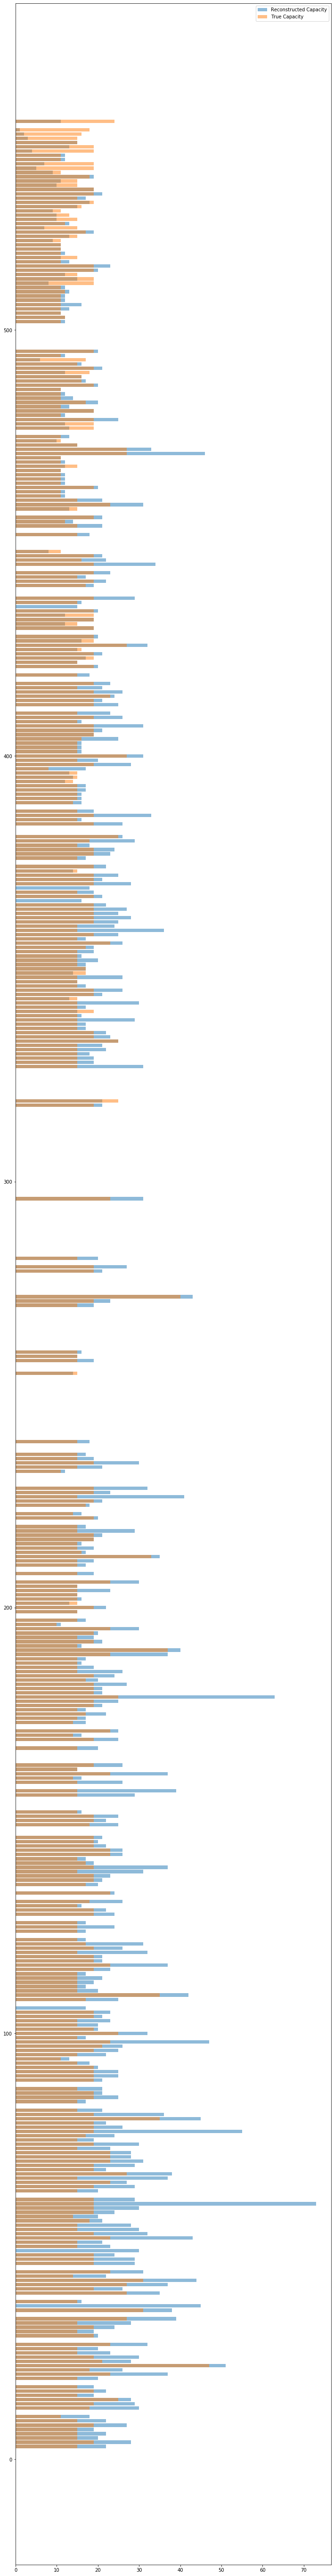

In [444]:
fig, ax = plt.subplots(figsize=(12,100))
ax.barh(validation_df['station_id'], validation_df['bikes_available'], label = 'Reconstructed Capacity', alpha = .5)
ax.barh(validation_df['station_id'], validation_df['capacity'], label = 'True Capacity', alpha = .5)
plt.legend()
plt.show()

In [144]:
def quantile01(x):
    return x.quantile(0.01)
def quantile99(x):
    return x.quantile(0.99)
def range01_99(x):
    return x.quantile(0.99) - x.quantile(0.01)


availability_df.groupby('station_id').agg({'bikes_available': [quantile01, quantile99, range01_99]}).loc[97]



bikes_available  min   -16
                 max    10
Name: 97, dtype: int64

In [142]:
station_info_df.loc[97]

name         Harvard University River Houses at DeWolfe St ...
latitude                                             42.369206
longitude                                           -71.117106
capacity                                                    21
Name: 97, dtype: object

In [88]:
availability_df.groupby('station_id').mean()

,change,bikes_available
station_id,,
1,0.004608,0.808756
3,0.000273,6.022696
4,0.000457,-2.144363
5,0.000091,0.289440
6,-0.000071,-3.894024
...,...,...
544,0.003751,4.933983
545,0.230769,1.769231
546,0.052632,0.210526


In [85]:
availability_df.groupby('station_id').max()

,time,change,bikes_available
station_id,,,
1,2021-10-03 23:55:22.232,1,12
3,2021-09-30 23:41:00.448,1,20
4,2021-09-30 23:42:17.307,1,14
5,2021-09-30 23:53:35.416,1,12
6,2021-09-30 23:55:01.368,1,8
...,...,...,...
544,2021-09-30 23:57:31.550,1,14
545,2021-09-29 22:32:04.942,1,3
546,2021-09-30 18:00:30.425,1,1


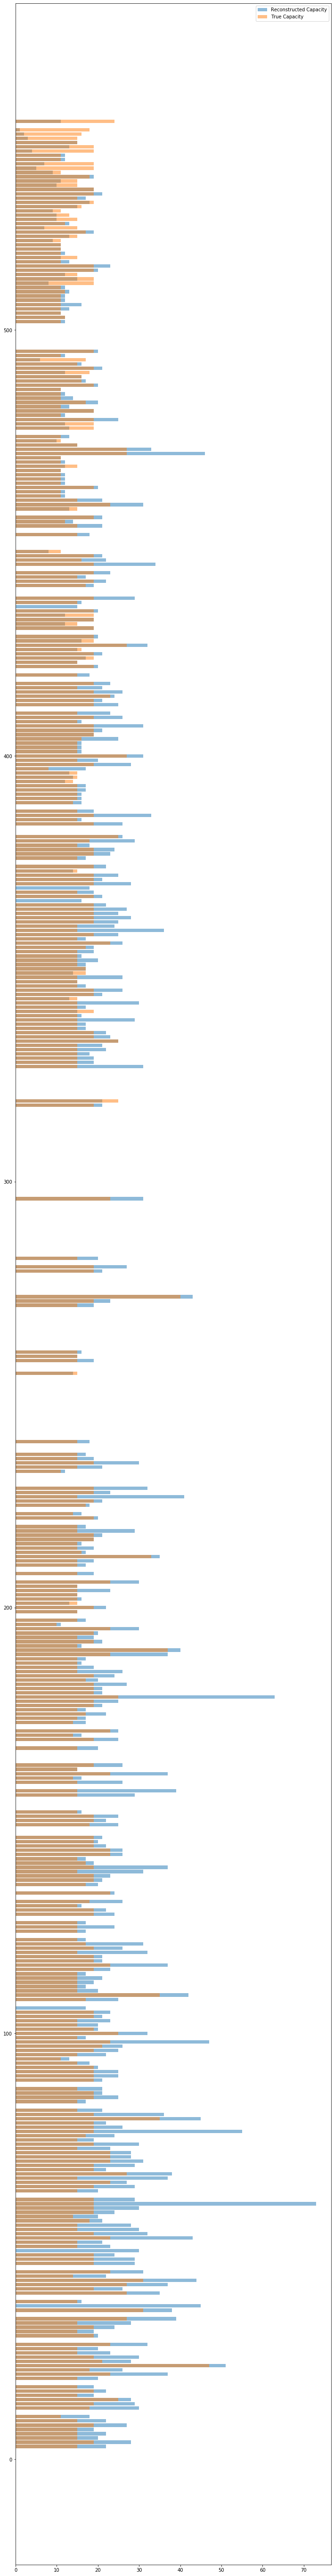

In [972]:
fig, ax = plt.subplots(figsize=(12,100))
ax.barh(validation_df['station_id'], validation_df['bikes_available'], label = 'Reconstructed Capacity', alpha = .5)
ax.barh(validation_df['station_id'], validation_df['capacity'], label = 'True Capacity', alpha = .5)
plt.legend()
plt.show()

#### Station Availability Exploration

In [147]:
sample_df = availability_df[availability_df.station_id == 97]

In [148]:
sample_df

,time,station_id,change,bikes_available
46,2020-07-01 00:30:14.267,97,1,1
168,2020-07-01 02:19:13.274,97,1,2
366,2020-07-01 05:52:27.862,97,-1,1
692,2020-07-01 07:00:34.203,97,-1,0
1078,2020-07-01 07:58:16.119,97,-1,-1
...,...,...,...,...
7202524,2021-09-30 23:44:12.379,97,-1,1
7202584,2021-09-30 23:46:26.195,97,1,2
7202651,2021-09-30 23:49:06.822,97,1,3
7202806,2021-09-30 23:54:38.656,97,-1,2


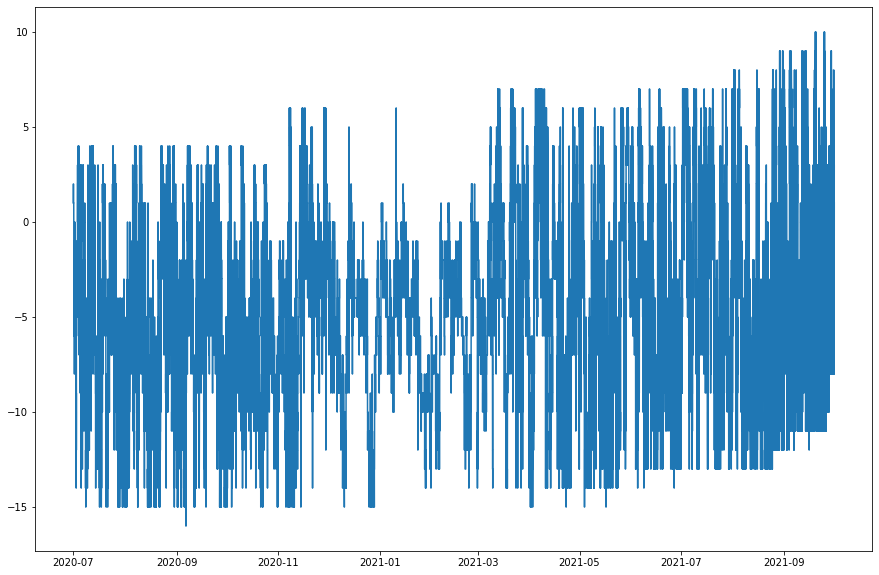

In [149]:
fig, ax = plt.subplots(figsize=(15,10))
ax.step(sample_df['time'],
        sample_df['bikes_available'])

In [971]:
(sample_df['bikes_available']-2).max()

24

In [151]:
station_info_df.loc[97]

name         Harvard University River Houses at DeWolfe St ...
latitude                                             42.369206
longitude                                           -71.117106
capacity                                                    21
Name: 97, dtype: object

### Notes <a id="notes"></a>
[Return to contents](#contents)

End goal:
- It's 9:15 am. I need to get to SEC at 9:45 am and I leave at 9:30 am. Will there be docks available for me? Or should I plan to walk instead?

- It's 1:30 pm right now. I need to get to the SEC at 2 pm. I need to decide whether to bike/walk. Will there be docks for me if I leave in 15 min, at 1:45 pm?

Considerations for predictions & response variable:
- Prediction horizon of 1 hour into the future. 
- Data in increments of 15 minutes.
- Get information about current bike/dock availability at 1:30 pm and use it to make predictions about whether there will be bikes to take out at the origin at 1:45 pm and docks to park at the destination at 2 pm.

Real-time data available:
- per each station, `num_bikes_available`, `num_docks_available`

Data Manipulation:
- Therefore, would want to reconstruct a historic dataset with the same information:
    - station
    - time (15 minute increments)
    - num_bikes_available
    - num_docks_available
- In addition, set up a script that would scrape data every 15 minutes from the container. Then compare the scraped live true data with the reconstructed data from October trips!

Next steps:
- Limit to 10 stations around Harvard and store counts 
- From monthly trips data to a "historic" dataset capturing # of bikes at the station at a given time over the last year
- For each artificial time stamp row, add a column by shifting: avialability in 15 min from that time, in 30 min, in 45 min.
- join weather data to historical data points, reliability of source? Limitation - aggregating the whole Boston. Find the same data source (Google API or weather) to continuously source data for weather from there
- convert days and months to one-hot before fitting the model
- create weekend column 
`# create weekend column as True for weekend days 
    df['weekend'] = [ d >= 5 for d in df['weekday']]`
- focus on just 10 stations around harvard campus
- validation of the data before feeding into the model
- model choice reasoning: what accomplish that couldn't be accomplished otherwise
- assumptions of the model
- Try multiple models. But state the trade-offs and hypothesis for why you are trying the models, based on the size, shape, and type of data.
- optimization and tuning of the model, improving and analysis
- interpretation, communication, impact, insights
- deploy to website: Flask, simple API to output results, Docker
- add a tab on website with visualization of trends

Train, test data:
- stratify by month and year

Prediction variables, algorithm:
- Take current point and establish a 15-min prediction horizon. Input: current availability at the destination, current time, day, week, month, weather (multiple). Output: number of docks available at the destination in 15 min, 30 min. Throw out last 3 data points for each station at the end of a work day (should be okay).

Models, approaches:
- linear regression with polynomial features
- Poisson and negative binomial regression models, Hurdle models
- random forest (RF)
- Bayesian neural network model
- XGBoost
- mean temperature, mean humidity, mean visibility, mean wind speed, precipitation, and events in a day (rainy, foggy, or sunny)

Takeaways:
- creative data sourcing and enables to do forecasting while previously it wasn’t possible

Future extensions, aspirations:
- add a destination (optional)
- app considers how many people are headed for a certain destination
- Hope to get more accurate data available; set up a script that will scrape every 15 minutes for the next 2 months to create a dataset myself.
- Integrate time series analysis and prediction.
- Consider interactions with other stations: find data for the number of docks at nearby stations and use it as an input feature; corresponds to the historic number of available docks interpolated from the trips data.

Caveats, difficulty, limitation notes:
- Other cities' bike-sharing services had more extensive datasets so I could switch to that, but I decided to find creative ways to deal with this incomplete data to develop a useful applications to the problem I faced
- Restrict to the period 7am-7pm: that's where most of the time-sensitive commuting begins; also, most rebalancing occurs at night - justify that claim? see where rebalancing trips happen.
- Artificially constructed availability so not 100% accurate.
- The number of bikes in the station at the beginning of the month is unknown.
- It doesn’t take into account rebalancing, bikes removed for maintenance or those added to the system.
- When the income of bikes suddenly stops for a while and the next is an outgoing bike, hints at the fact that station was at capacity. confirm by subtracting from the station # of docks in the dataset. 


A significant increase in the use of a bike sharing systems (BSSs) can cause imbalances in the distribution of bikes, creating logistical challenges. Moreover, imbalanced BSSs discourage bike riders, who may find it difficult to pick up or drop off a bike at their desired location.

The first step to solve this logistical problem is forecasting the availability of bikes and docks at each station in the BSS.

We used first- and second-order polynomial models because of their simplicity. Both DLMs were applied to a BSS in the San Francisco Bay Area. Different prediction horizons were used: 15, 30, 45, 60, and 120 minutes. 

Since riders can flexibly pick up and drop off a bike at different bike stations, these stations can become unbalanced and even unavailable (e.g., being full or empty) in popular trip origins and destinations

The users’ experience may be greatly impaired if they run into an unavailable station, which may ultimately hinder the user participation of bike sharing systems.

Accurate demand prediction of bike-sharing can effectively improve user experience and enhance brand competence
